# Extra Credit Project: Sentiment Analysis On Restaurant Reviews

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
# !{sys.executable} -m pip install sqlalchemy
from sqlalchemy import create_engine
from plotnine import *
from dfply import *
# !{sys.executable} -m pip install sqlite3
import sqlite3
import sqlalchemy
import seaborn as sns
import random

import altair

# Splitting data
from sklearn.model_selection import train_test_split
# Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Transformers
from transformers import pipeline
# Textblob!
from textblob import TextBlob


### Import cross_val_score and logistic regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

### Hyperparameter tuning with GridSearchCV and regularization parameter C
from sklearn.model_selection import GridSearchCV

### Import cross_val_score and naive bayes
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB

### Import cross_val_score and naive bayes bernoulli
# differs from multinomial NB’s rule in that it explicitly penalizes
#  the non-occurrence of a feature  that is an indicator for class , 
# where the multinomial variant would simply ignore a non-occurring feature.
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB

# Evaluating
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as esw
#### Stopwords from nltk
from nltk.corpus import stopwords
#### Stopwrods from spacy
from spacy.lang.en.stop_words import STOP_WORDS as spacy_sw

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Importing Bokeh objects and configuring to run in Jupyter Notebook
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.sampledata.iris import flowers
from bokeh.models import HoverTool
import math

output_notebook()

# For plotly
# Import the required packages
import plotly.express as px # Express Plotting Library
import plotly.graph_objects as go # Base/Core Plotting Library
import plotly.figure_factory as ff # Import figure factory
import plotly

Loading BokehJS ...

In [2]:
# Read in review table from yelp database
# import pandas as pd
myQuery =  '''SELECT * FROM review'''
reviews_df = pd.read_sql_table("review", "sqlite:///yelpHotelData.db")

In [3]:
print(f"There are {reviews_df.shape[0]} documents/reviews and {reviews_df.shape[1]} columns")

There are 688329 documents/reviews and 10 columns


In [4]:
reviews_df.head()

date                reviewID              reviewerID  \
0   6/8/2011            MyNjnxzZVTPq  IFTr6_6NI4CgCVavIL9k5g   
1  8/30/2011  BdD7fsPqHQL73hwENEDT-Q  c_-hF15XgNhlyy_TqzmdaA   
2  6/26/2009                BfhqiyfC  CiwZ6S5ZizAFL5gypf8tLA   
3  9/16/2010                      Ol  nf3q2h-kSQoZK2jBY92FOg   
4   2/5/2010  i4HIAcNTjabdpG1K4F5Q2g  Sb3DJGdZ4Rq__CqxPbae-g   

                                       reviewContent  rating  usefulCount  \
0  Let me begin by saying that there are two kind...       5           18   
1  The only place inside the Loop that you can st...       3            0   
2  I have walked by the Tokyo Hotel countless tim...       5           12   
3  If you are considering staying here, watch thi...       1            8   
4  This place is disgusting, absolutely horrible,...       3           11   

   coolCount  funnyCount flagged                 hotelID  
0         11          28       N  tQfLGoolUMu2J0igcWcoZg  
1          3           4       N  tQfLGoolUMu2J0igcWcoZg  
2         14          23       N  tQfLGoolUMu2J0igcWcoZg  
3          2           6       N  tQfLGoolUMu2J0igcWcoZg  
4          4           9       N  tQfLGoolUMu2J0igcWcoZg

In [5]:
reviews_df.dtypes

date             object
reviewID         object
reviewerID       object
reviewContent    object
rating            int64
usefulCount       int64
coolCount         int64
funnyCount        int64
flagged          object
hotelID          object
dtype: object

I wonder if I should convert a date into a datetime..

Our y-variable is our reviewContent.

And I guess, to double check, we have our `rating` column.

Anyways, I want to grab a smaller sample of our data, just for a little bit, just to speed up computation.

In [6]:
### Get smaller sample of the data to speed up computation later
small_df = reviews_df.sample(n = 100000)
# grab only 100,000 rows, not like 630 thousand rows.

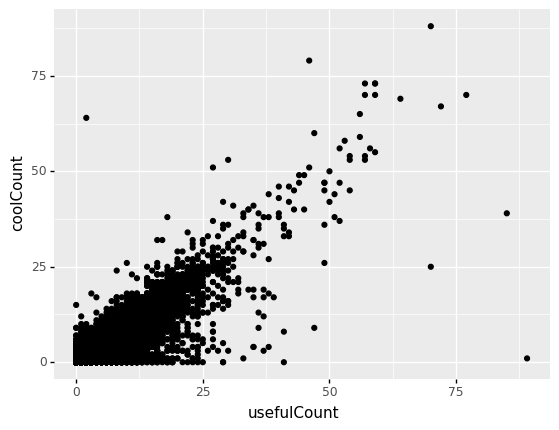

<ggplot: (109667687542)>

In [7]:
### Are useful reviews also cool?
(ggplot(small_df, aes(x="usefulCount",
                       y="coolCount")) +
geom_point())

So it looks like that the more useful a review is, the cooler it is.

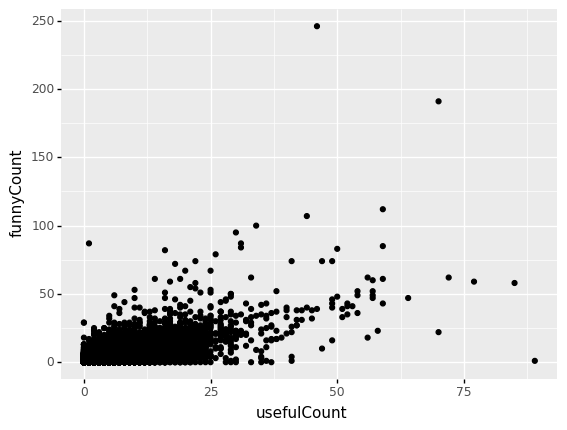

<ggplot: (109669729262)>

In [8]:
### Are useful reviews also funny?
(ggplot(small_df, aes(x="usefulCount",
                       y="funnyCount")) +
geom_point())

Except for a few outliers, a more useful review does tend to be funnier.

In [9]:
### Remove neutral ratings
# small_ = small_df[small_df["rating"] != 3]
### Create binary label 1=positive rating, 0 negative

small_df["pos_rev"] = np.where(small_df["rating"] >= 4, 1, 0)
# So maybe >4 or >=4
# basically, you get a 1 if review scored at least a 4. 0 otherwise.

In [10]:
### Get percent pos and neg: 32% postiive
pd.crosstab(small_df["pos_rev"], columns="count", normalize=True)

col_0      count
pos_rev         
0        0.36237
1        0.63763

So about 36% of our reviews ranged from mediocre to abysmal.

In [11]:
### Create X (features) and Y (target)
sentiment_label = small_df[["pos_rev"]] # target
sentiment_features = small_df[["reviewContent"]] # features, X-var

## Testing Textblob

This is good for detecting sentiment for unlabelled data!

In [12]:
phrase = TextBlob("good service")
print(phrase.sentiment)

Sentiment(polarity=0.7, subjectivity=0.6000000000000001)


Wow it's about 60% subjective/opinionated, and 0.7 on happiness score.

In [13]:
small_df.head()

date                reviewID              reviewerID  \
639063   11/9/2011  Smag-bp36bTWVB6eArN6FQ  uOqh11i95vvIb_JI9apGUg   
421992   9/27/2012  UVU6H16GN8zhoJQy7jTH7w  zJg4SBiWablLgygYKeJ8eg   
493579  10/29/2011  4iz1EITVGqC1HOZ0u1x9Nw  SXeMGP5lNgc03z7cl9Xihg   
138747   1/16/2009  gPjKcsbY43GH-KjG0tkc5w  L27OShvycGmVOkAxD1h86A   
317762   4/19/2006  soISVl38UZ3Bn4TCntjIng  yfy3v_n7BWiGs6pTf58i6A   

                                            reviewContent  rating  \
639063  My first time here. What a lot of tempting cho...       4   
421992  I believe this is the largest resort in Napa V...       2   
493579  If I had checked in every time I went here I w...       3   
138747  Elite event was fun as usual!  Saw all the Lak...       5   
317762  We went to the ultra hip and trendy Megu for J...       3   

        usefulCount  coolCount  funnyCount flagged                 hotelID  \
639063            0          0           0      NR  FEnEaQ3i7sTDlZg6Wl_-Zg   
421992            0          0           0      NR  wmsqMaemFDmvv78AVpKJcg   
493579            1          1           0      NR  JjXEPAR_tf3VCdngVS9GMg   
138747            6          5           4      NR  DXxWnVAavTJVIe4K0B803w   
317762            2          1           1      YR  AzITp8ydV97RFsVnxXn7cQ   

        pos_rev  
639063        1  
421992        0  
493579        0  
138747        1  
317762        0

In [14]:
small_df_sentiment = small_df.copy()
small_df_sentiment["sentiment"] = small_df_sentiment["reviewContent"].apply(lambda row: TextBlob(row).sentiment[0])
small_df_sentiment["subjectivity"] = small_df_sentiment["reviewContent"].apply(lambda row: TextBlob(row).sentiment[1])

I have now spawned another column called `sentiment`. It's a column that rates the sentiment of a review content on the positive score.

In [15]:
# scratch
small_df_sentiment

date                reviewID              reviewerID  \
639063   11/9/2011  Smag-bp36bTWVB6eArN6FQ  uOqh11i95vvIb_JI9apGUg   
421992   9/27/2012  UVU6H16GN8zhoJQy7jTH7w  zJg4SBiWablLgygYKeJ8eg   
493579  10/29/2011  4iz1EITVGqC1HOZ0u1x9Nw  SXeMGP5lNgc03z7cl9Xihg   
138747   1/16/2009  gPjKcsbY43GH-KjG0tkc5w  L27OShvycGmVOkAxD1h86A   
317762   4/19/2006  soISVl38UZ3Bn4TCntjIng  yfy3v_n7BWiGs6pTf58i6A   
...            ...                     ...                     ...   
285091    4/7/2011  eufpkDUcATcqsmB8mUXNbg  HqreDYtDsgN5HSZz8KH9_A   
685142   6/30/2008  Ogr-nQtpePmDI4QQMR7SbQ  ACUVZ4SiN0gni7dzVDm9EQ   
470895   8/13/2007  HHP7OAmvY8P6ZGvmRezz0w  kmE8w5Y785eZmodsx0V6Ag   
156559   9/15/2007  8gXYr8rX3r87v_k1t1T2Dg  lrvBE5PMCkvylXGSOJMsSA   
482554    6/4/2012  w-67S8x8YBvsg_TPCkY81g  ir689oBNmrJXOspb4yq_Jg   

                                            reviewContent  rating  \
639063  My first time here. What a lot of tempting cho...       4   
421992  I believe this is the largest resort in Napa V...       2   
493579  If I had checked in every time I went here I w...       3   
138747  Elite event was fun as usual!  Saw all the Lak...       5   
317762  We went to the ultra hip and trendy Megu for J...       3   
...                                                   ...     ...   
285091  This place has potential, but the terrible ser...       2   
685142  Is there anything you can't find at McGuckin? ...       5   
470895  I LOVE the A/B/C thing. I print off my A pass....       5   
156559  Got an impromptu invitation to go to Tempo lat...       4   
482554  Stopped here for the night on our cross countr...       3   

        usefulCount  coolCount  funnyCount flagged                 hotelID  \
639063            0          0           0      NR  FEnEaQ3i7sTDlZg6Wl_-Zg   
421992            0          0           0      NR  wmsqMaemFDmvv78AVpKJcg   
493579            1          1           0      NR  JjXEPAR_tf3VCdngVS9GMg   
138747            6          5           4      NR  DXxWnVAavTJVIe4K0B803w   
317762            2          1           1      YR  AzITp8ydV97RFsVnxXn7cQ   
...             ...        ...         ...     ...                     ...   
285091            6          0           0      YR  NLeDDTBDsR0pHFyqC2zgcw   
685142            5          5           5      NR  cO7jsGW9ma4GBNekBnWThA   
470895            1          0           0      YR  SjcKbcicabk1_Q9WriiGZQ   
156559            2          1           0      NR  jUpC2e91d5mFTH-9Y99moA   
482554            0          0           0      NR  HXNY9-_p1m41vK0-EqqsDQ   

        pos_rev  sentiment  subjectivity  
639063        1   0.202589      0.362976  
421992        0   0.266250      0.542500  
493579        0   0.138750      0.457500  
138747        1   0.215422      0.636364  
317762        0   0.250631      0.700253  
...         ...        ...           ...  
285091        0  -0.053016      0.524514  
685142        1   0.108929      0.396429  
470895        1   0.062222      0.730370  
156559        1   0.436364      0.597727  
482554        0   0.274182      0.453571  

[100000 rows x 13 columns]

Let's see if a positive rating scored high on the positive sentiment score.

In [16]:
small_df_sentiment.shape

(100000, 13)

This took way too long to spawn. I'll save this small dataframe (with sentiment and subjectivity included) into a CSV file, whatever.

In [20]:
small_df_sentiment.to_csv("smallDFSentiment.csv", index = False)

In [21]:
small_df_sentiment = pd.read_csv("smallDFSentiment.csv")

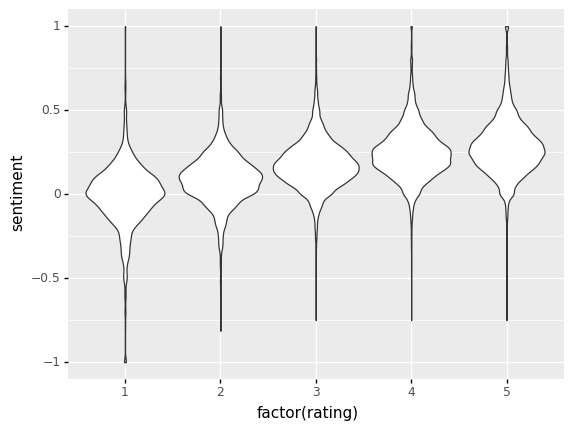

<ggplot: (109759267750)>

In [22]:
(
    small_df_sentiment.sample(n = 40000, random_state = 420) >>
    ggplot(aes(x = "factor(rating)", y = "sentiment")) +
#     geom_point(position = "jitter")
    geom_violin()
)

This procedure of plotting takes _such_ a long time, so that's why I subsetted for only 40,000 rows. And it looks like that as the rating changes, so does the sentiment, by a little bit. As the rating increases, the sentiment also increases. Seems like a good sign.

In [18]:
p = altair.Chart(small_df_sentiment.sample(n = 5000, random_state = 420)).mark_point().encode(
    x = altair.X(field = "rating", type = "ordinal", axis = altair.Axis(title = "Rating")),
    y = altair.Y(field = "sentiment", type = "quantitative", axis = altair.Axis(title = "Sentiment")),
    tooltip = "reviewContent"
    
).interactive()
p

alt.Chart(...)

Okay, so maybe simply finding the sentiment and/or rating ain't the best. I saw "heavenly OMG!" for a review and that got only a 0 on the positivity score what the Hell.

## Machine Learning

In [ ]:
### Create X (features) and Y (target)
# Y-variable: whether it was positive review
sentiment_label = small_df[["pos_rev"]] # target
sentiment_features = small_df[["reviewContent"]] # features, X-var

# Y-variable: the predicted sentiment.
sentiment_label = small_df_sentiment[["sentiment"]]
sentiment_features = small_df.drop(columns = ["pos_rev"], axis = 1)

In [23]:
### Split data into training and test
X_train, X_test, y_train, y_test = train_test_split(sentiment_features,
                                                    sentiment_label,
                                                   test_size = 0.2,
                                                    random_state = 420)

In [24]:
### Import and instantiate vectorizer
vec = CountVectorizer(min_df = 0.2, max_df = 0.7)

### Vectorize training text
reviews_xtrain = vec.fit_transform(X_train["reviewContent"])

### Vectorize test text
reviews_xtest = vec.transform(X_test["reviewContent"])

# TODO:

Suggestion: Somehow make a pipeline?

Make a method to do all that, but with the whole df?